In [108]:
import requests
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Data Loading

In [2]:
df_wilayah = pd.read_csv("../dataset/wilayah.csv")
df_wilayah.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 915181 entries, 0 to 915180
Data columns (total 12 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   id                               915181 non-null  int64 
 1   kode                             915181 non-null  object
 2   nama                             915181 non-null  object
 3   tingkat                          915181 non-null  int64 
 4   _is_fetched_presiden             915181 non-null  bool  
 5   updated_at                       915181 non-null  object
 6   created_at                       915181 non-null  object
 7   _is_fetched_dpr                  915181 non-null  bool  
 8   _is_fetched_dpd                  915181 non-null  bool  
 9   _is_fetched_dprd_provinsi        915181 non-null  bool  
 10  _is_fetched_dprd_kabupaten_kota  915181 non-null  bool  
 11  _is_fetched_wilayah              915181 non-null  bool  
dtypes: bool(6), int6

In [3]:
df_pemilu = pd.read_csv("../dataset/pemilu.csv")
df_pemilu.info()

/tmp/ipykernel_110154/3835573568.py:1: DtypeWarning: Columns (0,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pemilu = pd.read_csv("../dataset/pemilu.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823236 entries, 0 to 823235
Data columns (total 43 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   kode                 823236 non-null  object 
 1   provinsi_kode        823236 non-null  int64  
 2   kabupaten_kota_kode  823236 non-null  object 
 3   kecamatan_kode       823236 non-null  object 
 4   kelurahan_desa_kode  823236 non-null  object 
 5   tps                  823236 non-null  int64  
 6   suara_paslon_1       650005 non-null  float64
 7   suara_paslon_2       649895 non-null  float64
 8   suara_paslon_3       649863 non-null  float64
 9   chasil_hal_1         670516 non-null  object 
 10  chasil_hal_2         664486 non-null  object 
 11  chasil_hal_3         651910 non-null  object 
 12  suara_sah            532568 non-null  float64
 13  suara_total          532532 non-null  float64
 14  pemilih_dpt_j        532598 non-null  float64
 15  pemilih_dpt_l    

In [4]:
df = pd.read_csv("../dataset/all.csv")
df.info()

/tmp/ipykernel_110154/1669350698.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../dataset/all.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1775337 entries, 0 to 1775336
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   kode            object 
 1   tps             int64  
 2   page            int64  
 3   size_bytes      int64  
 4   extension       object 
 5   height          int64  
 6   width           int64  
 7   laplacian_blur  float64
 8   fft_blur        float64
 9   similarity      float64
 10  hash            object 
dtypes: float64(3), int64(5), object(3)
memory usage: 149.0+ MB


In [5]:
df["size_mb"] = df["size_bytes"] / 1024 / 1024
df["aspect_ratio"] = df["width"] / df["height"]
df["province_code"] = df["kode"].str.slice(0, 2)
df["district_code"] = df["kode"].str.slice(2, 4)
df["province_district_code"] = df["province_code"] + df["district_code"]
df["id"] = df[["kode", "page"]].apply(lambda x: f"{x.kode}_{x.page}", axis=1)

df.head()

,kode,tps,page,size_bytes,extension,height,width,laplacian_blur,fft_blur,similarity,hash,size_mb,aspect_ratio,province_code,district_code,province_district_code,id
0,3329082007033,33,1,1439908,jpg,1777,1000,1341.284676,44.759416,0.672840,edd71268dcb767638e4d6e617264c09e1e015a79d22a08...,1.373203,0.562746,33,29,3329,3329082007033_1
1,3329082007033,33,2,1631161,jpg,1777,1000,3354.153223,41.182217,0.714286,9f81c4fa7284beb3b9ef37b37cc46885c904b780f1a589...,1.555596,0.562746,33,29,3329,3329082007033_2
2,3329082007033,33,3,1181762,jpg,1777,1000,653.361715,33.343113,0.582192,8f1fcee455976e29101af1798ed9b4e99adecec66ce9f2...,1.127016,0.562746,33,29,3329,3329082007033_3
3,3202172008019,19,1,698625,jpg,1799,1000,173.245189,30.408100,0.656051,0aa79de0bb5334fe256dbe100d5ec89f3a3943ec319525...,0.666261,0.555864,32,02,3202,3202172008019_1
4,3202172008019,19,2,691647,jpg,1799,1000,144.869528,25.400169,0.791667,af67dba5884a880afb3baeb279d0a8a52bb5647ddb61ec...,0.659606,0.555864,32,02,3202,3202172008019_2


## EDA Pemilu

In [6]:
# Data for Table I.

def calc_page(col: str, dfc: pd.DataFrame):
    count = dfc[col].notna().sum()
    percentage = count / dfc.shape[0] * 100

    return f"{count} ({percentage:.2f}%)"

n_available = df_pemilu[["chasil_hal_1", "chasil_hal_2", "chasil_hal_3"]].notna().sum().sum()
n_all = df_pemilu.shape[0]
avail_percentage = n_available / (n_all * 3) * 100

print("Page 1:", calc_page("chasil_hal_1", df_pemilu))
print("Page 2:", calc_page("chasil_hal_2", df_pemilu))
print("Page 3:", calc_page("chasil_hal_3", df_pemilu))
print(f"Available: {n_available}")
print(f"Uploaded: {n_available}/{n_all} ({avail_percentage:.2f}%)")

Page 1: 670516 (81.45%)
Page 2: 664486 (80.72%)
Page 3: 651910 (79.19%)
Available: 1986912
Uploaded: 1986912/823236 (80.45%)


## Threshold

In [7]:
def plot_hist(dfc: pd.DataFrame, col: str, bins: int = 50):
    p01, p05, p50, p95, p99 = dfc[col].quantile([0.01, 0.05, 0.5, 0.95, 0.99])
    print(f"p01: {p01:.2f}, p05: {p05:.2f}, p50: {p50:.2f}, p95: {p95:.2f}, p99: {p99:.2f}")

    fig, ax = plt.subplots(figsize=(4, 3))
    sns.histplot(dfc[col], bins=bins, ax=ax, kde=True)
    ax.vlines([p05, p50, p95], 0, ax.get_ylim()[1], colors='r', linestyles='dashed')
    plt.show()

In [8]:
df.describe()

,tps,page,size_bytes,height,width,laplacian_blur,fft_blur,similarity,size_mb,aspect_ratio
count,1.775337e+06,1.775337e+06,1.775337e+06,1.775337e+06,1.775337e+06,1.775337e+06,1.775337e+06,1.775337e+06,1.775337e+06,1.775337e+06
mean,1.716072e+01,1.999967e+00,8.455490e+05,1.725438e+03,1.003234e+03,5.528434e+02,2.548121e+01,7.583028e-01,8.063783e-01,5.885703e-01
std,4.834146e+01,8.164972e-01,2.051663e+05,2.033648e+02,8.127373e+01,5.851770e+02,7.231264e+00,1.074617e-01,1.956618e-01,8.529745e-02
min,1.000000e+00,1.000000e+00,1.613800e+04,1.230000e+02,2.590000e+02,1.996282e+00,-4.271721e+01,0.000000e+00,1.539040e-02,1.147974e-01
25%,3.000000e+00,1.000000e+00,7.239440e+05,1.579000e+03,1.000000e+03,1.749465e+02,2.009062e+01,6.951220e-01,6.904068e-01,5.624297e-01
50%,7.000000e+00,2.000000e+00,8.427740e+05,1.777000e+03,1.000000e+03,3.694890e+02,2.612002e+01,7.657143e-01,8.037319e-01,5.627462e-01
75%,1.600000e+01,3.000000e+00,9.597250e+05,1.778000e+03,1.000000e+03,7.447304e+02,3.078949e+01,8.412698e-01,9.152651e-01,6.337136e-01
max,9.500000e+02,3.000000e+00,2.246782e+07,1.379200e+04,9.421000e+03,2.515327e+04,1.050378e+02,1.000000e+00,2.142698e+01,8.130081e+00


In [9]:
# Data for Table II.
df["page"].value_counts()

page
1    591809
2    591778
3    591750
Name: count, dtype: int64

p01: 24.36, p05: 59.09, p50: 369.49, p95: 1615.62, p99: 2554.86


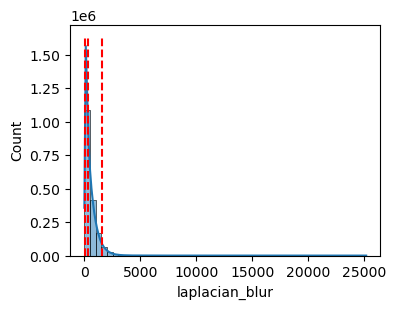

In [10]:
plot_hist(df, "laplacian_blur")

p01: 8.93, p05: 13.48, p50: 26.12, p95: 36.30, p99: 40.83


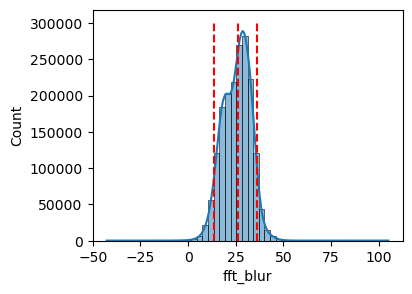

In [11]:
plot_hist(df, "fft_blur")

p01: 0.44, p05: 0.57, p50: 0.77, p95: 0.91, p99: 0.94


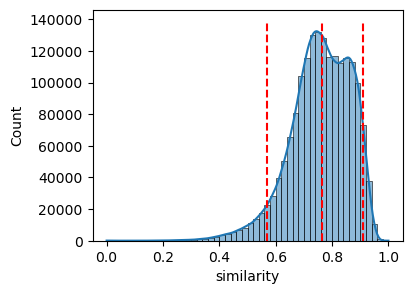

In [12]:
plot_hist(df, "similarity")

p01: 0.41, p05: 0.53, p50: 0.80, p95: 1.08, p99: 1.25


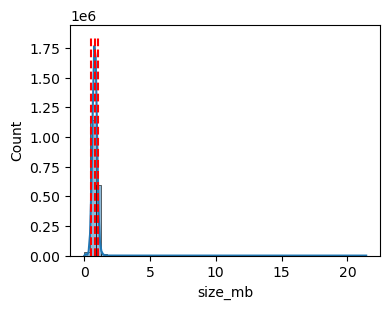

In [13]:
plot_hist(df, "size_mb")

p01: 1315.00, p05: 1451.00, p50: 1777.00, p95: 2000.00, p99: 2057.00


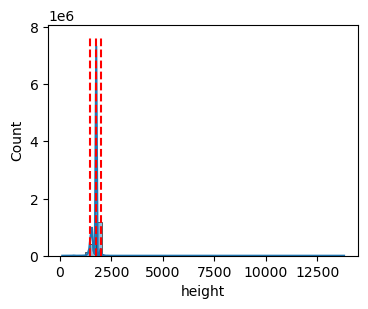

In [14]:
plot_hist(df, "height")

p01: 1000.00, p05: 1000.00, p50: 1000.00, p95: 1000.00, p99: 1000.00


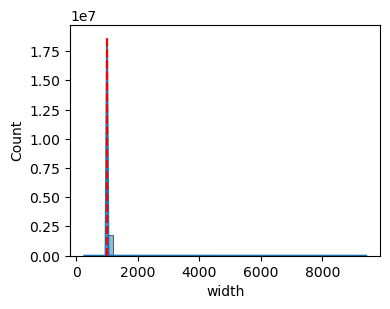

In [15]:
plot_hist(df, "width")

p01: 0.50, p05: 0.50, p50: 0.56, p95: 0.69, p99: 0.75


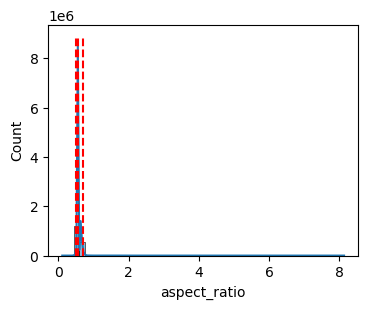

In [16]:
plot_hist(df, "aspect_ratio")

## Document Blur

### By Laplace

In [17]:
blur_laplace = df[~df["laplacian_blur"].between(100, 2000)]["id"]
blur_laplace_pct = len(blur_laplace) / df.shape[0] * 100

print(f"Blurry by Laplace: {len(blur_laplace)} ({blur_laplace_pct:.2f}%)")

Blurry by Laplace: 250314 (14.10%)


### By FFT

In [18]:
blur_fft = df[~df["fft_blur"].between(20, 50)]["id"]
blur_fft_pct = len(blur_fft) / df.shape[0] * 100

print(f"Blurry by FFT: {len(blur_fft)} ({blur_fft_pct:.2f}%)")

Blurry by FFT: 438167 (24.68%)


In [19]:
n_blur_total = len(set(blur_laplace.tolist() + blur_fft.tolist()))
n_blur_total_pct = n_blur_total / df.shape[0] * 100

print(f"Total: {n_blur_total} ({n_blur_total_pct:.2f}%)")

Total: 561267 (31.61%)


## Document Recognition

### By Aspect Ratio

In [20]:
rec_ar = df[~df["aspect_ratio"].between(0.5, 1.7, inclusive="both")]["id"]
rec_ar_pct = len(rec_ar) / df.shape[0] * 100

print(f"Aspect Ratio: {len(rec_ar)} ({rec_ar_pct:.2f}%)")

Aspect Ratio: 27724 (1.56%)


### By Size

In [21]:
rec_size = df[(df["width"] < 1000) & (df["height"] < 1000)]["id"]
rec_size_pct = len(rec_size) / df.shape[0] * 100

print(f"Size: {len(rec_size)} ({rec_size_pct:.2f}%)")

Size: 820 (0.05%)


### By ORB Similarity

In [22]:
rec_orb = df[df["similarity"] < 0.5]["id"]
rec_orb_pct = len(rec_orb) / df.shape[0] * 100

print(f"ORB: {len(rec_orb)} ({rec_orb_pct:.2f}%)")

ORB: 37876 (2.13%)


In [23]:
n_rec_total = len(set(rec_ar.tolist() + rec_size.tolist() + rec_orb.tolist()))
n_rec_total_pct = n_rec_total / n_available * 100

print(f"Total: {n_rec_total} ({n_rec_total_pct:.2f}%)")

Total: 65313 (3.29%)


## Document Hash

In [24]:
df_dupe = df[df.duplicated(["hash"])]
duplicate_count = df_dupe.shape[0]
duplicate_percentage = (duplicate_count / df.shape[0]) * 100

print(f"Duplicate: {duplicate_count} ({duplicate_percentage:.2f}%)")
df_dupe.head(5)

Duplicate: 7056 (0.40%)


,kode,tps,page,size_bytes,extension,height,width,laplacian_blur,fft_blur,similarity,hash,size_mb,aspect_ratio,province_code,district_code,province_district_code,id
524,1302042002055,55,3,721986,jpg,1408,1000,432.308552,26.252858,0.716981,3ec5d60af5b6a7985241a801745d10d6047468b0989256...,0.688540,0.710227,13,02,1302,1302042002055_3
575,1302042002050,50,3,1028476,jpg,1556,1000,475.296281,38.646929,0.815029,32b05ac47fc19dae42acc10697bfd3d583700984c2eb77...,0.980831,0.642674,13,02,1302,1302042002050_3
656,3273051005033,33,3,562613,jpg,1466,1000,27.076437,17.386980,0.853147,746bf6e430a43ce200443b31d9d04e7cbf95e944c8cef1...,0.536550,0.682128,32,73,3273,3273051005033_3
683,1302042002049,49,3,988659,jpg,1777,1000,369.573750,26.094502,0.803681,53a4f27a3b91dabc7fd4462074dfe6c4eb4f15cfcc264e...,0.942859,0.562746,13,02,1302,1302042002049_3
788,1509021001003,3,3,976431,jpg,2000,1000,437.539688,29.324650,0.887640,7b0c79c7ba0a8c587750d5b0047138f702df95a85d241c...,0.931197,0.500000,15,09,1509,1509021001003_3


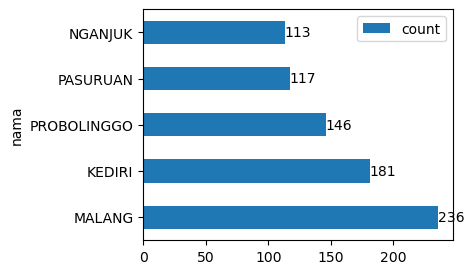

In [25]:
df_dupe_count_by_area = df_dupe.groupby(["province_district_code"]).size().sort_values(ascending=False)
df_wilayah_small = df_wilayah[df_wilayah["kode"].isin(df_dupe_count_by_area.index)][["kode", "nama"]].copy().set_index("kode")
df_wilayah_small["count"] = df_dupe_count_by_area

ax = df_wilayah_small.sort_values("count", ascending=False).head(5).set_index("nama").plot.barh(figsize=(4, 3))
ax.bar_label(ax.containers[0])
plt.show()

In [26]:
# count unique kode per hash
unique_kode_by_hash = df_dupe.groupby(["hash"])["kode"].nunique().sort_values(ascending=False)

# sum of hash with more than 1 unique kode
# meaning there are hash with multiple kode (identical document submitted to multiple TPS)
print((unique_kode_by_hash > 1).sum())
unique_kode_by_hash.head()

5


hash
d8e47b5b9c236517a028d7055aadc86e2b27426bbebd29fbc3870bc72986bcc8    3
a02fa672b5f8dd5aa718b21b2598966df2fc0a758134d312c4de403888da89f9    2
db5d72e0fd5e8d10634b1156f121781190380745051423cea70769c54ab3a567    2
8c46a569aa200ed9bf2aa0f4ce75b08f7b528f8378c16f24807f8c69f593c563    2
3dacde93c737aec9a26c2b0dd2c0fff9ed254059f5d3fcee905eb2b45e3f69f3    2
Name: kode, dtype: int64

In [35]:
unique_kode_by_hash[(unique_kode_by_hash > 1)].sum()

11

## Data Explorer

In [116]:
def get_image(kode: str):
    row = next(df_pemilu[df_pemilu["kode"] == kode].itertuples())
    print(f"TPS: {row.tps}")
    print(f"Code: {kode}")
    print(f"Address: {row.provinsi_nama}, {row.kabupaten_kota_nama}, {row.kecamatan_nama}, {row.kelurahan_desa_nama}")

    fig, ax = plt.subplots(1, 3, figsize=(6, 3))
    image_urls = [row.chasil_hal_1, row.chasil_hal_2, row.chasil_hal_3]
    for i, url in enumerate(image_urls):
        response = requests.get(url)
        image = np.asarray(bytearray(response.content), dtype="uint8")
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)

        ax[image_urls.index(url)].imshow(image)
        ax[image_urls.index(url)].axis("off")
        ax[image_urls.index(url)].set_title(f"Page {i+1}")

    plt.show()

In [160]:
# df[df["similarity"] < 0.1].sort_values("similarity", ascending=True)
# df[df["aspect_ratio"] > 0.9]
df[df["hash"] == "a02fa672b5f8dd5aa718b21b2598966df2fc0a758134d312c4de403888da89f9"]
# df[df["fft_blur"] > 80]

,kode,tps,page,size_bytes,extension,height,width,laplacian_blur,fft_blur,similarity,hash,size_mb,aspect_ratio,province_code,district_code,province_district_code,id
1055991,3327122017003,3,3,363334,jpg,3565,2315,797.886063,26.597981,0.772727,a02fa672b5f8dd5aa718b21b2598966df2fc0a758134d3...,0.346502,0.649369,33,27,3327,3327122017003_3
1058592,3327122017005,5,3,363334,jpg,3565,2315,797.886063,26.597981,0.772727,a02fa672b5f8dd5aa718b21b2598966df2fc0a758134d3...,0.346502,0.649369,33,27,3327,3327122017005_3
1516515,3327122017001,1,3,363334,jpg,3565,2315,797.886063,26.597981,0.772727,a02fa672b5f8dd5aa718b21b2598966df2fc0a758134d3...,0.346502,0.649369,33,27,3327,3327122017001_3


TPS: 3
Code: 3327122017003
Address: JAWA TENGAH, PEMALANG, COMAL, KANDANG


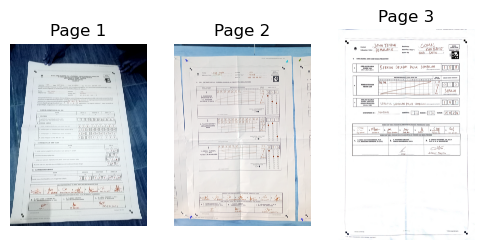

In [161]:
get_image("3327122017003")

## RECAP

In [29]:
total_problems = len(set(blur_laplace.tolist() + blur_fft.tolist() + rec_ar.tolist() + rec_size.tolist() + rec_orb.tolist() + df_dupe["id"].tolist()))
total_problems_pct = total_problems / df.shape[0] * 100

print(f"Total Problems: {total_problems} ({total_problems_pct:.2f}%)")

Total Problems: 612282 (34.49%)


## Visualization

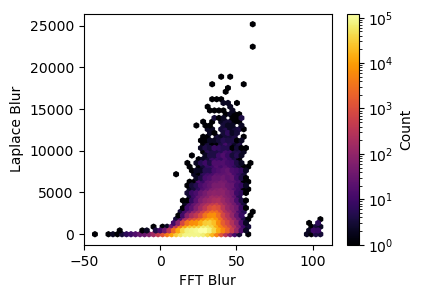

In [46]:
fig, ax = plt.subplots(figsize=(4, 3))
hb = ax.hexbin(df["fft_blur"], df["laplacian_blur"], gridsize=50, cmap='inferno', mincnt=1, bins="log")
ax.set_ylabel("Laplace Blur")
ax.set_xlabel("FFT Blur")
fig.colorbar(hb, ax=ax, label="Count")
plt.show()